# Lasso vs Ridge Regression:  Numerical Analysis Final Project

In [135]:
using Pkg
using LinearAlgebra
using DataFrames
using CSV
using Statistics
using Plots
using StatsPlots

## Import data

In [27]:
matrix_data_temp = CSV.File("median_housing_cost_data.tsv") |> Tables.matrix
matrix_data = matrix_data_temp[:,2:9];

In [28]:
matrix_target_temp = CSV.File("housing_cost_targets.tsv") |> Tables.matrix
matrix_target = matrix_target_temp[:,2];

In [29]:
# train test split (test proportion of 20%) - test has 4128 samples, train has 16512 samples

matrix_data_train = matrix_data[1:16512, :];
matrix_data_test = matrix_data[16513:20640, :];

matrix_target_train = matrix_target[1:16512, :];
matrix_target_test = matrix_target[16513:20640, :];

In [30]:
# normalize data (min max normalize)
#comment this out and run cell above if we wish to do it without normalizing

for i in 1:size(matrix_data_train)[2]
    
    matrix_data_train[:,i] = (matrix_data_train[:,i] .- findmin(matrix_data_train[:,i])[1]) ./ (findmax(matrix_data_train[:,i])[1] - findmin(matrix_data_train[:,i])[1]);
    matrix_data_test[:,i] = (matrix_data_test[:,i] .- findmin(matrix_data_test[:,i])[1]) ./ (findmax(matrix_data_test[:,i])[1] - findmin(matrix_data_test[:,i])[1]);

end

matrix_target_train = (matrix_target_train .- findmin(matrix_target_train)[1]) ./ (findmax(matrix_target_train)[1] - findmin(matrix_target_train)[1]);
matrix_target_test = (matrix_target_test .- findmin(matrix_target_test)[1]) ./ (findmax(matrix_target_test)[1] - findmin(matrix_target_test)[1]);


## Motivating factor

In [31]:
# talk about median household costs and how maximizing posterior probabilities to estimate cost is goal

## Regression tasks derived from maximizing posterior probabilities

Here we will derive from the Bayesian approach of maximizing w on a posterior probability the corresponding regression task:

For We derive the ridge regression task from the following.
We have an observed data likelihood: $P(t|w) \approx N(t|y, 1)$  
and a prior distribution: $P(w|\lambda) \approx N(w|0,\frac{1}{\lambda})$

We wish to maximize the posterior probability: $P(w|t) = P(t|w) P(w|\lambda)$

$argmax_{w}(P(w|t)) = argmax_{w}(P(t|w) P(w|\lambda))$

$= argmax_{w}(\prod\limits_{i=1}^{N}P(t_i|w)\prod\limits_{j=0}^{M}P(w_j|0,\lambda))$

$= argmax_{w}(\prod\limits_{i=1}^{N}N(t|y_i,1)\prod\limits_{j=0}^{M}N(w_j|0,\frac{1}{\lambda}))$

$\propto argmax_{w}(\sum\limits_{i=1}^{N}ln(N(t_i|y_i,1)) + \sum\limits_{j=0}^{M}ln(N(w_j|0,\lambda)))$

$= argmax_{w}(\sum\limits_{i=1}^{N}ln(e^{\frac{-1}{2}(t_i - y_i)^{T}1(t_i - y_i)}) + \sum\limits_{j=0}^{M}ln(e^{\frac{-1}{2}(w - 0)^{T}\lambda(w - 0)}))$

$= argmin_{w}(-(\frac{-1}{2}\sum\limits_{i=1}^{N}(t_i - y_i)^2 - \frac{\lambda}{2} \sum\limits_{j=0}^{M} w_j^2))$

$= argmin_{w}(\frac{1}{2}\sum\limits_{i=1}^{N}(t_i - y_i)^2 + \frac{\lambda}{2} \sum\limits_{j=0}^{M} w_j^2)$

As we can see, we have successfully derived the ridge (L2) regression formulation

We derive the lasso regression task from the following.
We have an observed data likelihood: $P(t|w) \approx N(t|y, 1)$  
and a prior distribution: $P(w|\lambda) \approx Poisson(w|\frac{1}{\lambda})$

We wish to maximize the posterior probability: $P(w|t) = P(t|w) P(w|\lambda)$

$argmax_w(P(w|t)) = argmax_w(P(t|w) P(w|\lambda))$

$=argmax_w(\prod\limits_{i=1}^{N}N(t_i|y_i,1) \prod\limits_{j=0}^{M}Poisson(w|\frac{1}{\lambda}))$

$\propto argmax_w(\sum\limits_{i=1}^{N}ln(N(t_i|y_i, 1)) + \sum\limits_{j=0}^{M}ln(Poisson(\frac{1}{\lambda})))$

$\propto argmax_w(\sum\limits_{i=1}^{N}ln(e^{\frac{-1}{2}(t_i-y_i)^T1(t_i-y_i)}) + \sum\limits_{j=0}^{M}ln(e^{-w_j\lambda}))$

$=argmin_w(-(\frac{-1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 - \lambda\sum\limits_{j=0}^{M}|w_j| ))$

$=argmin_w(\frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \lambda\sum\limits_{j=0}^{M}|w_j| )$

As we can see, we have successfully derived the lasso (L1) regression formulation

## Solutions to regression tasks

Now that we have derived the formulation for ridge regression, let's derive a solution.

$argmin_w(\frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \lambda\sum\limits_{j=0}^{M}w_j^2 )$ , inherently implies we should differentiate argument to be minimized with respect to the argument we are trying to find.

If we define: $J(w) = \frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \frac{\lambda}{2}\sum\limits_{j=0}^{M}w_j^2$ , then:

$J(w) = \frac{1}{2}(t-Xw)^T(t-Xw) + \frac{\lambda}{2}w^Tw$

$ = \frac{1}{2} (t^Tt - t^TXw - w^TX^Tt + w^TX^TXw) + \frac{\lambda}{2}w^Tw$

We next differentiate $J(w)$ with respect to $w$ : 

$\frac{\partial J(w)}{\partial w} = \frac{1}{2}(0 - 2t^TX + 2w^TX^TX) + \frac{\lambda}{2}2w^TI$

$ = -t^TX + w^TX^TX + \lambda w^TI$

Since, $\frac{\partial J(w)}{\partial w} = 0$, we can thus rearrange terms to get:

$t^TX = w^TX^TX + \lambda w^TI$

$(t^TX)^T = (w^TX^TX)^T + (\lambda w^TI)^T$

$X^Tt = X^TXw + \lambda wI$

$X^Tt = w(X^TX + \lambda I)$

so we thus get as our final solution:  
$w = (X^TX + \lambda I)^{-1}X^Tt$

Now that we have a derived a formulation for lasso regression, let's find a solution. We will quickly realize in attempting to derive it, that there is no simple closed form solution to lasso regression. There exists a complex closed form solution that uses proximity functions, but this is not easy to implement in code. Thus, we will solve a solution to lasso regression numerically with a numerical method, more specifically, gradient descent.

If we define: $J(w) = \frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \lambda\sum\limits_{j=0}^{M}|w_j|$ , then:

$J(w) = \frac{1}{2}(t-Xw)^T(t-Xw) + \lambda |w|$

$ = \frac{1}{2} (t^Tt - t^TXw - w^TX^Tt + w^TX^TXw) + \lambda |w| $

Thus we have it that: $\frac{\partial J(w)}{\partial w} = 0$    

and therefore, $-t^TX + w^TX^TX + \alpha \lambda$, such that, $\alpha = sign(w)$

$ => -(X^T(t-Xw + \alpha \lambda))$

From here, we can see that we cannot solve for w easily with a closed form solution. We thus will use this derivative and express it in the form of the gradient of MSE as the update term in gradient descent - a numerical method used to approximate and converge upon the solution.

in gradient descent we have it that: $w^{(t+1)} <= w^{(t)} - \eta \nabla_w MSE(w)$

To express what we have thus far into the gradient of MSE term, all me must do is multiply by 2 and divide by the number of samples since it is "mean" squared error: $\nabla_w MSE(w) = -\frac{2}{m}(X^T(t-Xw + b + \alpha \lambda))$, where b is the bias that comes from the gradient descent, which we define as: $-\frac{2}{m}\sum\limits_{i=1}^{N}(t_i-Xw)$

So in gradient descent we have it that:  
$w^{(t+1)} <= w^{(w)} - \eta (-\frac{2}{m}(X^T(t-Xw + b + \alpha \lambda)))$  
$b^{(t+1)} <= b^{(t)} - \eta (-\frac{2}{m}\sum\limits_{i=1}^{N}(t_i-Xw)) $

These are the update equations we will use to iterate towards the solution for the parameters for lasso regression.

## Code solutions for regression tasks

In [32]:
function linear_regression_ridge(X,y,lambda)
    
    s = size(X)[2]
    Im =1* Matrix(I, s, s)
    
    w = inv(transpose(X)*X + lambda*Im) * transpose(X) * y
    
    pred = X * w
    
    err = y - pred
    
    return w    
    
end

linear_regression_ridge (generic function with 1 method)

In [33]:
function linear_regression_lasso_GD(X, y, lambda)
    
    learning_rate = .025
    iterations = 8000
    l1_penalty = lambda
    n = size(X)[2] # feature number
    m = size(X)[1] #sample number
    w = zeros(n) # shape of the params (feature #)
    b = 0
    
    for i in 1:iterations        
        y_pred = zeros(m)
        for k in 1:m
            y_pred[k] = dot(X[k,:], w) + b
        end
        
        #calculate gradients
        dW = zeros(n) # shape of the params (feature #)
        for j in 1:n
            if w[j] > 0  
                dW[j] = ( -1 * (2 * (dot(X[:,j], y - y_pred) ) ) + l1_penalty) ./ m
            else
                dW[j] = ( -1 * (2 * (dot(X[:,j], y - y_pred) ) ) - l1_penalty) ./ m
            end
        end
        
        db = - 2 * sum(y - y_pred) ./ m
        
        w = w - learning_rate*dW
        b = b - learning_rate*db
        
    end
    
    return w, b
    
end

linear_regression_lasso_GD (generic function with 1 method)

In [34]:
#for performing linear regression on some data X with provided coefficients w
function linear_regression_test(X,w)
    
    pred = X * w
    
    return pred
    
end

linear_regression_test (generic function with 1 method)

In [35]:
#for performing linear regression on some data X with provided coefficients w for gradient descent regression
function linear_regression_test_GD(X,w,b)
    
    m = size(X)[1]
    pred = zeros(m)
    for k in 1:m
        pred[k] = dot(X[k,:], w) + b
    end
    
    return pred
    
end

linear_regression_test_GD (generic function with 1 method)

## Analysis of algorithms: conditioning, complexities, and flop counts

## Conditioning

### Ridge

In [36]:
x = zeros(0)
push!(x, 2)
x

1-element Vector{Float64}:
 2.0

In [116]:
# This Function checks the conditioning of the Ridge Regression
# by checking each individual operation to see if it is well conditioned.
# If each individual operation of the regression is well conditioned, 
# then the entire algorithm is well conditioned. If a part of the 
# regression is ill conditioned then the algorithm is not optimal.
function ridge_conditioning(X,y,lambda)
    k = zeros(0)                                           # vector containing all condition numbers
    
    s  = size(X)[2]
    push!(k,1)                                                       # s  = size(X)[2]
    
    Im = 1 * Matrix(I, s, s)
    push!(k,1)                                                       # Im = 1 * Matrix(I, s, s)
    
    w = inv(transpose(X)*X + lambda*Im) * transpose(X) * y
    A = transpose(X)*X
    push!(k, norm(transpose(X)*X) * norm(inv(transpose(X)*X)))       # xT * x
    b = lambda*Im
    push!(k, norm(lambda) * norm(inv(lambda)))                       # lambda * I
    C = A + b
    push!(k, norm(A)*norm(inv(A)) + norm(b)*norm(inv(b)))            # A + b
    D = inv(C)
    push!(k, norm(inv(C))*norm(C))                                   # inv(C)
    E = transpose(X) * y
    push!(k, (norm(transpose(X)) * norm(y)) / norm(transpose(X) * y))# xT * y
    F = D * E
    push!(k, (norm(D) * norm(E))/norm(D*E))                          # D * E
    
    pred = X * w
    push!(k, (norm(X) * norm(w))/norm(X*w))                           # X * w
        
    err = y - pred
    push!(k, norm(err))                                              # y - pred
    
    return k
end

ridge_conditioning (generic function with 1 method)

## Time complexity

### Ridge Regression

In [38]:
# Ridge Regression Function Decomposed to show computations:
# Parameters- X: (m x n), y: (m x 1), lambda: constant
function ridge_TC(X,y,lambda)
    s  = size(X)[2]                          # O(1)      [CHANGED [1] to [2]... Correct (grab m or n)?]
    Im = 1 * Matrix(I, s, s)                 # O(n^2)    [Constructing (n x n) I Matrix]
    xT = transpose(X)                        # O(1)      [(m x n)] => (n x m)
    xT_X = xT * X                            # O(m^2*n)  [(n x m) * (m x n)] => (n x n)
    l_Im = lambda * Im                       # O(n^2)    [Scalar multiplication of (n x n) matrix]
    xT_lambda = l_Im + xT_X                  # O(n^2)    [Scalar addition of (n x n) matrix]
    inverse = inv(xT_lambda)                 # O(n^3)    [Inverse (Gauss Elimination) with matrix of size (n x n)]
    w = inverse * xT                         # O(n^2*m)  [(n x n) * (n x m)] => (n x m)
    w *= y                                   # O(m*n)    [(n x m) * (m x 1)] => (n x 1)
    pred = X * w                             # O(m*n)    [(m x n) * (n x 1)] => (m x 1)
    err = y - pred                           # O(m)      [(m x 1) - (m x 1)] => (m x 1)
    
    return w, pred, err                      # O(1)
end

ridge_TC (generic function with 1 method)

In [39]:
# Time Complexities Added
# O(n^3) + O(n^2*m) + O(m^2*n) + O(n^2) + O(n^2) + O(n^2) + O(m*n) + O(m*n) + O(m) + O(1) + O(1) + O(1)

# Final Time Complexity: 
# O(n^3) + O(n^2*m) + O(m^2*n)

# Note: If m >> n (Data points >> Features), time complexity can be reduced to O(m^2*n)

In [40]:
# Variable Dimensions
# --------------------------------
# lambda = constant
# (n x n) = xT_X, inverse, Im, l_Im xT_lambda
# (n x m) = xT
# (n x 1) = w
# (m x n) = X
# (m x 1) = y, pred, err

### Lasso Regression

In [41]:
# Lasso Regression Function Decomposed to show computations:
# Parameters- X: (m x n), y: (m x 1), lambda: constant
function lasso_TC(X,y,lambda)  
    xT = transpose(X)              # O(1)        [(m x n)] => (n x m)
    xT_X = xT * X                  # O(m^2*n)    [(n x m) * (m x n)] => (n x n)
    xInv = inv(xT_X)               # O(n^3)      [Inverse (Gauss Elimination) with matrix of size n]
    moore_pen = xInv * xT          # O(n^2*m)    [(n x n) * (n x m)] => (n x m)
    w = moore_pen * y              # O(m*n)      [(n x m) * (m x 1)] => (n x 1)
    w_lam = (abs.(w) .- lambda)    # O(n)        [Scalar subtraction of (n x 1) matrix]
    w_lasso = sign.(w) .* w_lam    # O(n)        [Scalar multiplication of (n x 1) matrix]
    pred = X * w_lasso             # O(m*n)      [(m x n) * (n x 1)] => (m x 1)
    err = y - pred                 # O(m)        [(m x 1) - (m x 1)] => (m x 1)
    
    return w_lasso, pred, err      # O(1)
end

lasso_TC (generic function with 1 method)

In [42]:
# Variable Dimensions
# -------------------------
# lambda = constant
# (n x n) = xT_X
# (n x m) = xT, moore_pen
# (n x 1) = w, w_lam, w_lasso
# (m x n) = X
# (m x 1) = y, pred, err

In [43]:
# Time Complexity References
# ----------------------------------------
# Size(X)       : O(1)
# References    : [https://stackoverflow.com/questions/21614298/what-is-the-runtime-of-array-length, https://blog.finxter.com/python-list-length-whats-the-runtime-complexity-of-len/, ]

# Transpose(X)  : O(1)    
# References    : [https://www.mathworks.com/matlabcentral/answers/495668-what-s-the-transpose-complexity-big-o-in-matlab, https://stackoverflow.com/questions/61157101/in-julia-transpose-operator]

# Inverse(X)    : Worst Case-O(n^3) (Gauss Elimination), Best Case O(n^2.373)
# References    : [https://stackoverflow.com/questions/54890422/inv-versus-on-julia]

# Matrix *      : (m x n) * (n * p) => O(n*m*p), O(n^3)-O(n^2.72...)
# References    : [https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra]

# Matrix -      : O(m*n)
# References    : [https://www.geeksforgeeks.org/different-operation-matrices/]

# Matrix(I,s,s) : O(n^2)
# References    : []

## Space Complexity

### Ridge Regression

In [44]:
# Actual Ridge Algorithm
function ridge_SC(X,y,lambda)
    n = size(X)[2]                                          # O(1)    1 variable
    Im = 1 * Matrix(I, n, n)                                # O(n^2)  (n x n) matrix
    w = inv(transpose(X)*X + lambda*Im) * transpose(X) * y  # O(n)    (n x 1) matrix
    pred = X * w                                            # O(m)    (m x 1) matrix
    err = y - pred                                          # O(m)    (m x 1) matrix
    
    return w, pred, err                                     # O(1)    Return on Stack
end

ridge_SC (generic function with 1 method)

In [45]:
# Total Space Complexity
# O(n^2) + O(n) + O(m) + O(m) + O(1) + O(1)

# O(n^2) + O(m)

### Lasso Regression

In [46]:
# Actual Ridge Algorithm
function lasso_SC(X,y,lambda)
    moore_pen = inv(transpose(X)*X) * transpose(X)    # O(m*n) (n x m) matrix
    w = moore_pen * y                                 # O(n)   (n x 1) matrix
    w_lasso = sign.(w) .* (abs.(w) .- lambda)         # O(n)   (n x 1) matrix
    pred = X * w_lasso                                # O(m)   (m x 1) matrix
    err = y - pred                                    # O(m)   (m x 1) matrix
    
    return w_lasso, pred, err                         # O(1)   Return on Stack
end

lasso_SC (generic function with 1 method)

In [47]:
# Total Space Complexity
# O(m*n) + O(n) + O(n) + O(m) + O(m) + O(1)

# O(m*n)

In [48]:
# Space Complexity References
# -------------------------------
# [Space Complexity Calculates Temp Vars?] https://www.studytonight.com/data-structures/space-complexity-of-algorithms

## Flop Counts

### Ridge Regression

In [49]:
# Ridge Regression Function Decomposed:
# Parameters- X: (m x n), y: (m x 1), lambda: constant
function ridge_FC(X,y,lambda)
    n  = size(X)[2]                          # 0
    Im = 1 * Matrix(I, n, n)                 # n^2          [Constructing (n x n) I Matrix]
    xT = transpose(X)                        # 0            [(m x n)] => (n x m)
    xT_X = xT * X                            # m^2*n        [(n x m) * (m x n)] => (n x n)
    l_Im = lambda * Im                       # n^2          [Scalar multiplication of (n x n) matrix]
    xT_lambda = l_Im + xT_X                  # n^2          [Scalar addition of (n x n) matrix]
    inverse = inv(xT_lambda)                 # n^3 (approx) [Gauss Elimination with matrix of size (n x n)]
    w = inverse * xT                         # n^2*m        [(n x n) * (n x m)] => (n x m)
    w *= y                                   # m*n          [(n x m) * (m x 1)] => (n x 1)
    pred = X * w                             # m*n          [(m x n) * (n x 1)] => (m x 1)
    err = y - pred                           # m            [(m x 1) - (m x 1)] => (m x 1)
    
    return w, pred, err                      # 0
end

ridge_FC (generic function with 1 method)

In [50]:
# Flop Count
# n^2 + (m^2*n) + n^2 + n^2 + n^3 + n^2*m + m*n + m*n + m
# Total Flop Count = n^3 + (3+m)n^2 + n*m^2 + 2m*n + m

# Note: In the worst case, Gaussian Elimination for n x n will take ((5/6)n^3+(3/2)n^2-(7/6)n) floating point operations.
# Worst Case Flops = (5/6)n^3 + ((9/2)+m)n^2 + n*m^2 + ((5/6)m)n + m

### Lasso Regression

In [51]:
# Ridge Regression Function Decomposed:
# Parameters- X: (m x n), y: (m x 1), lambda: constant
function lasso_TC(X,y,lambda)  
    xT = transpose(X)              # 0
    xT_X = xT * X                  # m^2*n        [(n x m) * (m x n)] => (n x n)
    xInv = inv(xT_X)               # n^3 (approx) [Gauss Elimination with matrix of size (n x n)]
    moore_pen = xInv * xT          # n^2*m        [(n x n) * (n x m)] => (n x m)
    w = moore_pen * y              # m*n          [(n x m) * (m x 1)] => (n x 1)
    w_lam = (abs.(w) .- lambda)    # n            [Scalar subtraction of (n x 1) matrix]
    w_lasso = sign.(w) .* w_lam    # n            [Scalar multiplication of (n x 1) matrix]
    pred = X * w_lasso             # m*n          [(m x n) * (n x 1)] => (m x 1)
    err = y - pred                 # m            [(m x 1) - (m x 1)] => (m x 1)
    
    return w_lasso, pred, err      # 0
end

lasso_TC (generic function with 1 method)

In [52]:
# Flop Count
# Flops = n^3 + n*m^2 + m*n^2 + 2m*n + 2n + m

# Note: In the worst case, Gaussian Elimination for n x n will take ((5/6)n^3+(3/2)n^2-(7/6)n) floating point operations.
# Worst Case Flops = (5/6)n^3 + n*m^2 + (3/2 + m)*n^2 + 2m*n + (5/6)n + m

In [53]:
# Flop Count References:
# Flops For nxn Gaussian Elimination: http://web.mit.edu/18.06/www/Fall15/Matrices.pdf

## Perform regression tasks on data

In [54]:
function r_squared(targets, predictions)
    
    mean_target = mean(targets)
    
    ssr = 0
    sst = 0
    
    for i in 1:size(targets)[1]
        
        ssr += (targets[i] - predictions[i])^2
        sst += (targets[i] - mean_target)^2
        
    end
    
    r_sq = 1 - (ssr/sst)
    
end

r_squared (generic function with 1 method)

In [126]:
lambdas = [.000001, .00001, .0001, .001, .01, .05, .1, .5, 1.5, 5, 10, 12, 15, 18, 20];
k = [0,0,0,0,0,0,0,0,0,0]

10-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [127]:
optimal_l1_params = zeros(8)
optimal_l2_params = zeros(8)

optimal_l1_r_sq = -1
optimal_l2_r_sq = -1

optimal_l1_lam = -1000
optimal_l2_lam = -1000

#conditioning


for it in lambdas
    
    parameters_l2 = linear_regression_ridge(matrix_data_train,matrix_target_train, it);
    parameters_l1, b_l1 = linear_regression_lasso_GD(matrix_data_train,matrix_target_train, it);
    
    #conditioning
    k = ridge_conditioning(matrix_data_train,matrix_target_train,it)
    K = hcat(K, k)
    
    predictions_l2 = linear_regression_test(matrix_data_test, parameters_l2);
    predictions_l1 = linear_regression_test_GD(matrix_data_test, parameters_l1, b_l1);
    predictions_l1 = reshape(predictions_l1, length(predictions_l1), 1);
    
    r_sq_l2 = r_squared(sort(matrix_target_test, dims=1), sort(predictions_l2, dims=1));
    r_sq_l1 = r_squared(sort(matrix_target_test, dims=1), sort(predictions_l1, dims=1));
    
    if r_sq_l2 > optimal_l2_r_sq
        optimal_l2_r_sq = r_sq_l2
        optimal_l2_params = parameters_l2
        optimal_l2_lam = it
    end
    
    if r_sq_l1 > optimal_l1_r_sq
        optimal_l1_r_sq = r_sq_l1
        optimal_l1_params = parameters_l1
        optimal_l1_lam = it
    end
    
    
end

In [128]:
println("The optimal lambda coefficient for l1 norm is:", optimal_l1_lam)
println("The optimal lambda coefficient for l2 norm is:", optimal_l2_lam)
println("The optimal r^2 value for l1 norm is:", optimal_l1_r_sq)
println("The optimal r^2 value for l2 norm is:", optimal_l2_r_sq)

The optimal lambda coefficient for l1 norm is:1.0e-6
The optimal lambda coefficient for l2 norm is:5.0
The optimal r^2 value for l1 norm is:0.9046659108542182
The optimal r^2 value for l2 norm is:0.8722628864709415


In [131]:
 # Display the conditioning of each iteration of the ridge regression
K'

17×10 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0  1.0  42455.3  1.0  42463.3   1010.96  …   352.823   2.89617  21.1178
 2.0  2.0  42456.3  2.0  42464.3   1011.96      353.823   3.89617  22.1178
 1.0  1.0  42455.3  1.0  42463.3  42455.1      2003.11   21.1109   20.3829
 1.0  1.0  42455.3  1.0  42463.3  42453.9      2003.11   21.1103   20.3829
 1.0  1.0  42455.3  1.0  42463.3  42441.7      2003.12   21.1043   20.3829
 1.0  1.0  42455.3  1.0  42463.3  42320.4   …  2003.16   21.0441   20.3829
 1.0  1.0  42455.3  1.0  42463.3  41146.5      2003.57   20.4615   20.3836
 1.0  1.0  42455.3  1.0  42463.3  36663.4      2005.03   18.2358   20.3959
 1.0  1.0  42455.3  1.0  42463.3  32325.8      2005.97   16.0839   20.4228
 1.0  1.0  42455.3  1.0  42463.3  17117.4      1974.86    8.6704   20.6337
 1.0  1.0  42455.3  1.0  42463.3   8365.23  …  1717.77    4.87724  20.8357
 1.0  1.0  42455.3  1.0  42463.3   3258.34      977.901   3.34407  20.9835
 1.0  1.0  42455.3  1.0  42463.3   1828.18    

## Evaluation of algorithm performance

In [13]:
# r^2 and qq plot

In [225]:
# already have the r^2 values, possibly just recalculate them for the optimal params

In [226]:
# make a qq-plot

In [161]:
# hard code in the optimal regularization coefficients to function
parameters_l2 = linear_regression_ridge(matrix_data_train,matrix_target_train, 5);
parameters_l1, b_l1 = linear_regression_lasso_GD(matrix_data_train,matrix_target_train, .00001);
    
predictions_l2 = linear_regression_test(matrix_data_test, parameters_l2);
predictions_l1 = linear_regression_test_GD(matrix_data_test, parameters_l1, b_l1);
predictions_l1 = reshape(predictions_l1, length(predictions_l1), 1);
    
sorted_test_targets = sort(matrix_target_test, dims=1)
sorted_l2_preds = sort(predictions_l2, dims=1)
sorted_l1_preds = sort(predictions_l1, dims=1)
r_sq_l2 = r_squared(sorted_test_targets, sorted_l2_preds);
r_sq_l1 = r_squared(sorted_test_targets, sorted_l1_preds);

In [21]:
# TO DO: someone please do this, my julia won't let me add the Plots package. Can someone graph the QQ plots here plz.
# it should concist of 2 qq plots. each should have a x=y line. 
# first qq plot should have sorted_l1_preds vs sorted_test_targets
# second qq plot should have sorted_l2_preds vs sorted_test_targets
# then under each qq plot just print(r_sq_l#) then it is done

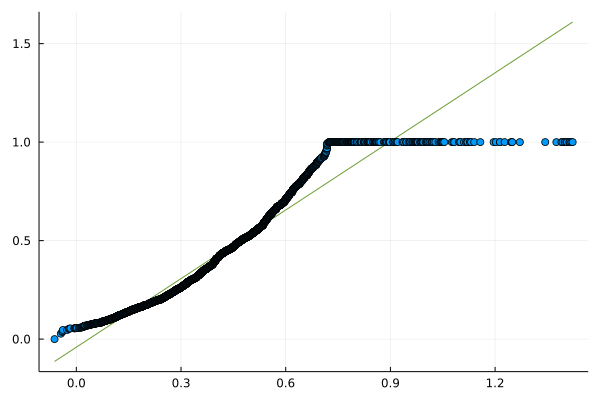

In [176]:
plot(
 qqplot(sorted_l1_preds[:], sorted_test_targets[:], qqline = :fit), # qqplot of two samples, show a fitted regression line
)

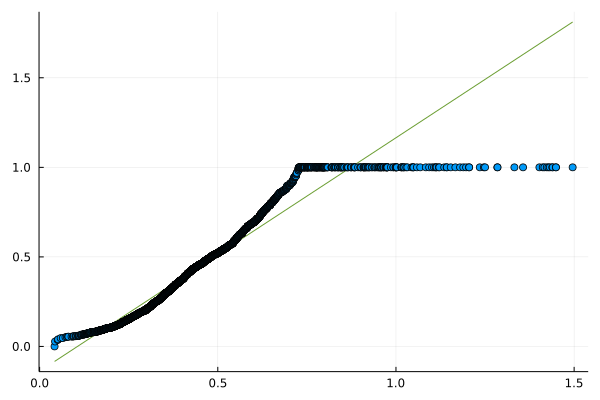

In [175]:
plot(
qqplot(sorted_l2_preds[:], sorted_test_targets[:], qqline = :fit), # qqplot of two samples, show a fitted regression line
)

In [178]:
print(r_sq_l1)

0.9046658818867916

In [179]:
print(r_sq_l2)

0.8722628864709415

## Conclusion